In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import os.path
import re
import sys
import tarfile

import numpy as np
from six.moves import urllib
import tensorflow as tf

import matplotlib
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
from PIL import Image

%matplotlib inline


In [2]:
# Copyright 2015 The TensorFlow Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

"""Simple image classification with Inception.

Run image classification with Inception trained on ImageNet 2012 Challenge data
set.

This program creates a graph from a saved GraphDef protocol buffer,
and runs inference on an input JPEG image. It outputs human readable
strings of the top 5 predictions along with their probabilities.

Change the --image_file argument to any jpg image to compute a
classification of that image.

Please see the tutorial and website for a detailed description of how
to use this script to perform image recognition.

https://tensorflow.org/tutorials/image_recognition/
"""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import os.path
import re
import sys
import tarfile

import numpy as np
from six.moves import urllib
import tensorflow as tf

from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

%matplotlib inline

FLAGS = None

# pylint: disable=line-too-long
DATA_URL = 'http://download.tensorflow.org/models/image/imagenet/inception-2015-12-05.tgz'
# pylint: enable=line-too-long


class NodeLookup(object):
  """Converts integer node ID's to human readable labels."""

  def __init__(self,
               label_lookup_path=None,
               uid_lookup_path=None):
    if not label_lookup_path:
      label_lookup_path = os.path.join(
          FLAGS.model_dir, 'imagenet_2012_challenge_label_map_proto.pbtxt')
    if not uid_lookup_path:
      uid_lookup_path = os.path.join(
          FLAGS.model_dir, 'imagenet_synset_to_human_label_map.txt')
    self.node_lookup = self.load(label_lookup_path, uid_lookup_path)

  def load(self, label_lookup_path, uid_lookup_path):
    """Loads a human readable English name for each softmax node.

    Args:
      label_lookup_path: string UID to integer node ID.
      uid_lookup_path: string UID to human-readable string.

    Returns:
      dict from integer node ID to human-readable string.
    """
    if not tf.gfile.Exists(uid_lookup_path):
      tf.logging.fatal('File does not exist %s', uid_lookup_path)
    if not tf.gfile.Exists(label_lookup_path):
      tf.logging.fatal('File does not exist %s', label_lookup_path)

    # Loads mapping from string UID to human-readable string
    proto_as_ascii_lines = tf.gfile.GFile(uid_lookup_path).readlines()
    uid_to_human = {}
    p = re.compile(r'[n\d]*[ \S,]*')
    for line in proto_as_ascii_lines:
      parsed_items = p.findall(line)
      uid = parsed_items[0]
      human_string = parsed_items[2]
      uid_to_human[uid] = human_string

    # Loads mapping from string UID to integer node ID.
    node_id_to_uid = {}
    proto_as_ascii = tf.gfile.GFile(label_lookup_path).readlines()
    for line in proto_as_ascii:
      if line.startswith('  target_class:'):
        target_class = int(line.split(': ')[1])
      if line.startswith('  target_class_string:'):
        target_class_string = line.split(': ')[1]
        node_id_to_uid[target_class] = target_class_string[1:-2]

    # Loads the final mapping of integer node ID to human-readable string
    node_id_to_name = {}
    for key, val in node_id_to_uid.items():
      if val not in uid_to_human:
        tf.logging.fatal('Failed to locate: %s', val)
      name = uid_to_human[val]
      node_id_to_name[key] = name

    return node_id_to_name

  def id_to_string(self, node_id):
    if node_id not in self.node_lookup:
      return ''
    return self.node_lookup[node_id]


def create_graph():
  """Creates a graph from saved GraphDef file and returns a saver."""
  # Creates graph from saved graph_def.pb.
  with tf.gfile.FastGFile(os.path.join(
      FLAGS.model_dir, 'classify_image_graph_def.pb'), 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    _ = tf.import_graph_def(graph_def, name='')


def run_inference_on_image(image):
  """Runs inference on an image.

  Args:
    image: Image file name.

  Returns:
    Nothing
  """
  if not tf.gfile.Exists(image):
    tf.logging.fatal('File does not exist %s', image)
  image_data = tf.gfile.FastGFile(image, 'rb').read()

  # Creates graph from saved GraphDef.
  create_graph()

  with tf.Session() as sess:
    # Some useful tensors:
    # 'softmax:0': A tensor containing the normalized prediction across
    #   1000 labels.
    # 'pool_3:0': A tensor containing the next-to-last layer containing 2048
    #   float description of the image.
    # 'DecodeJpeg/contents:0': A tensor containing a string providing JPEG
    #   encoding of the image.
    # Runs the softmax tensor by feeding the image_data as input to the graph.
    softmax_tensor = sess.graph.get_tensor_by_name('softmax:0')
    predictions = sess.run(softmax_tensor,
                           {'DecodeJpeg/contents:0': image_data})
    predictions = np.squeeze(predictions)

    # Creates node ID --> English string lookup.
    node_lookup = NodeLookup()

    top_k = predictions.argsort()[-FLAGS.num_top_predictions:][::-1]
    results = []
    for node_id in top_k:
      human_string = node_lookup.id_to_string(node_id)
      score = predictions[node_id]
      results.append((human_string, score))
      #print('%s (score = %.5f)' % (human_string, score))
    return results


def maybe_download_and_extract():
  """Download and extract model tar file."""
  dest_directory = FLAGS.model_dir
  if not os.path.exists(dest_directory):
    os.makedirs(dest_directory)
  filename = DATA_URL.split('/')[-1]
  filepath = os.path.join(dest_directory, filename)
  if not os.path.exists(filepath):
    def _progress(count, block_size, total_size):
      sys.stdout.write('\r>> Downloading %s %.1f%%' % (
          filename, float(count * block_size) / float(total_size) * 100.0))
      sys.stdout.flush()
    filepath, _ = urllib.request.urlretrieve(DATA_URL, filepath, _progress)
    print()
    statinfo = os.stat(filepath)
    print('Successfully downloaded', filename, statinfo.st_size, 'bytes.')
  tarfile.open(filepath, 'r:gz').extractall(dest_directory)


def main():
  FLAGS.model_dir='/tmp/imagenet'
  maybe_download_and_extract()
#   image = (FLAGS.image_file if FLAGS.image_file else
#            os.path.join(FLAGS.model_dir, 'cropped_panda.jpg'))
#   run_inference_on_image(image)


if __name__ == '__main__':
  parser = argparse.ArgumentParser()
  # classify_image_graph_def.pb:
  #   Binary representation of the GraphDef protocol buffer.
  # imagenet_synset_to_human_label_map.txt:
  #   Map from synset ID to a human readable string.
  # imagenet_2012_challenge_label_map_proto.pbtxt:
  #   Text representation of a protocol buffer mapping a label to synset ID.
  parser.add_argument(
      '--model_dir',
      type=str,
      default='/tmp/imagenet',
      help="""\
      Path to classify_image_graph_def.pb,
      imagenet_synset_to_human_label_map.txt, and
      imagenet_2012_challenge_label_map_proto.pbtxt.\
      """
  )
  parser.add_argument(
      '--image_file',
      type=str,
      default='',
      help='Absolute path to image file.'
  )
  parser.add_argument(
      '--num_top_predictions',
      type=int,
      default=5,
      help='Display this many predictions.'
  )
  FLAGS, unparsed = parser.parse_known_args()
  main()
  #tf.app.run(main=main, argv=[sys.argv[0]] + unparsed)

In [3]:
def download_url(url, filename=None):
  """Download and extract model tar file."""
  dest_directory = FLAGS.model_dir
  if not os.path.exists(dest_directory):
    os.makedirs(dest_directory)
  if not filename: 
    filename = url.split('/')[-1]
  filepath = os.path.join(dest_directory, filename)
  if not os.path.exists(filepath):
#     def _progress(count, block_size, total_size):
#       sys.stdout.write('\r>> Downloading %s %.1f%%' % (
#           filename, float(count * block_size) / float(total_size) * 100.0))
#       sys.stdout.flush()
    #filepath, _ = urllib.request.urlretrieve(url, filepath, _progress)
    filepath, _ = urllib.request.urlretrieve(url, filepath)
    #print()
    statinfo = os.stat(filepath)
    #print('Successfully downloaded', filename, statinfo.st_size, 'bytes.')
  return filepath


In [4]:
def download_show_and_run(url, filename=None):
    image = download_url(url, filename)
    if image:
        matplotlib.rc('xtick', labelsize=20) 
        matplotlib.rc('ytick', labelsize=20) 
        results = run_inference_on_image(image)
        labels, scores = zip(*results)

        fig, ax = plt.subplots(figsize=(18, 5))
        pil_im = Image.open(image, 'r')


        y_pos = np.arange(len(labels))
        ax.barh(y_pos, scores, align='center',color='green', ecolor='black')
        ax.set_yticks(y_pos)
        ax.set_yticklabels(labels)
        ax.invert_yaxis()  # labels read top-to-bottom
        ax.set_xlabel('Score', fontsize=20)
        ax.set_title('Classification', fontsize=20)  
        divider = make_axes_locatable(ax)
       
        axright = divider.append_axes("right", size=6, pad=1.0)
        axright.imshow(np.asarray(pil_im))
        
     

        plt.tight_layout()
        plt.show()


Intercepted!


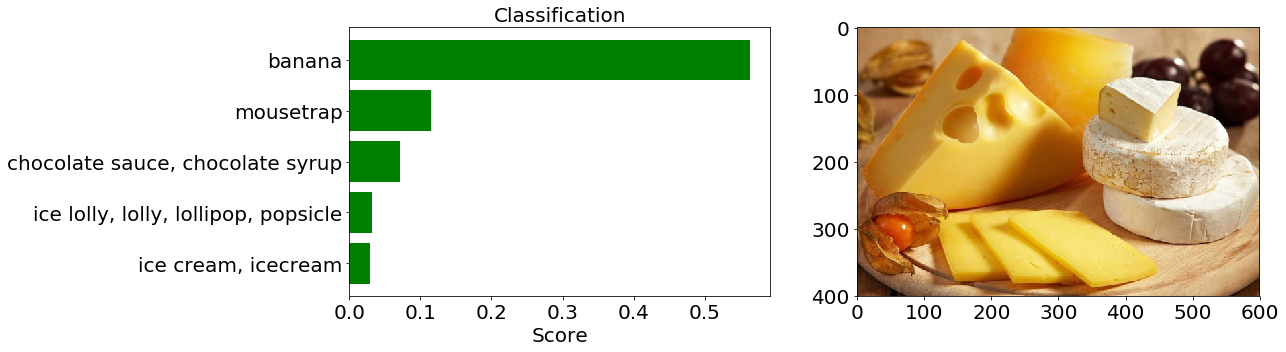

In [5]:
download_show_and_run('http://www4.pictures.zimbio.com/mp/26-j9dYPwm_l.jpg', 'cheese.jpg')

Intercepted!


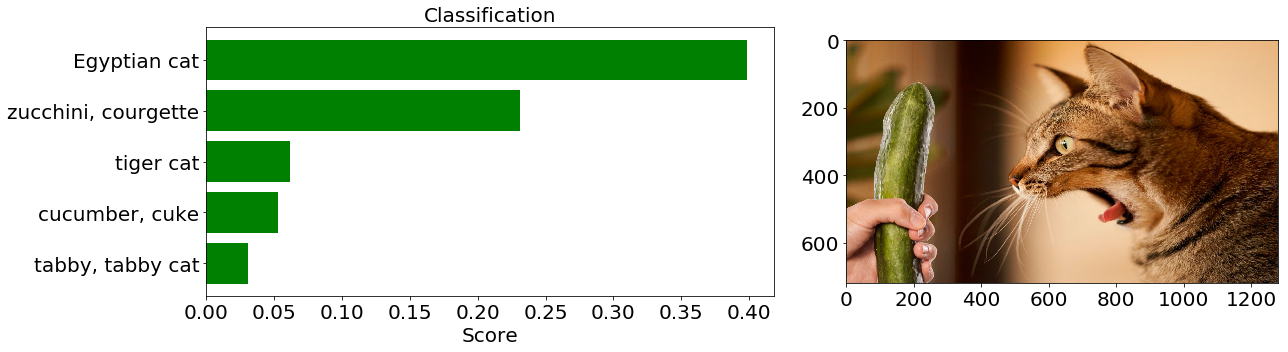

In [6]:
download_show_and_run('https://i.ytimg.com/vi/cNycdfFEgBc/maxresdefault.jpg', 'cat-cu.jpg')

Intercepted!


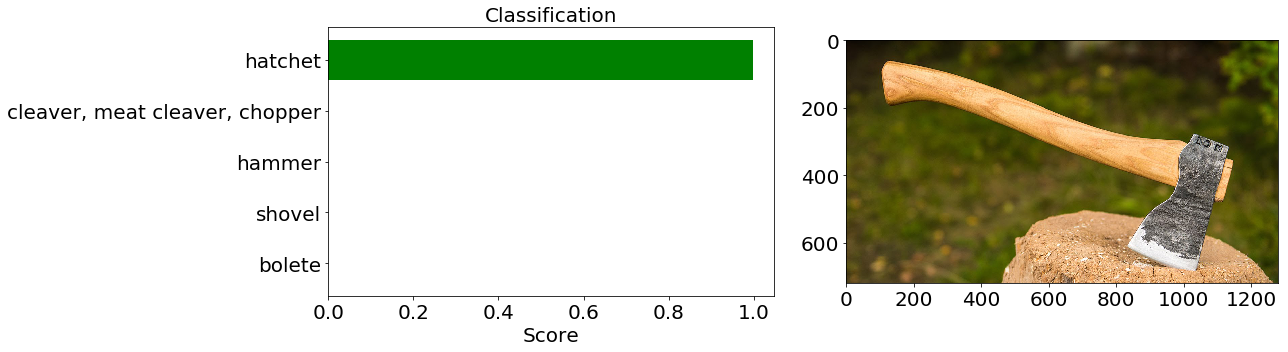

In [7]:
download_show_and_run('https://i.ytimg.com/vi/2Hva7kH8DEo/maxresdefault.jpg', 'axe.jpg')

Intercepted!


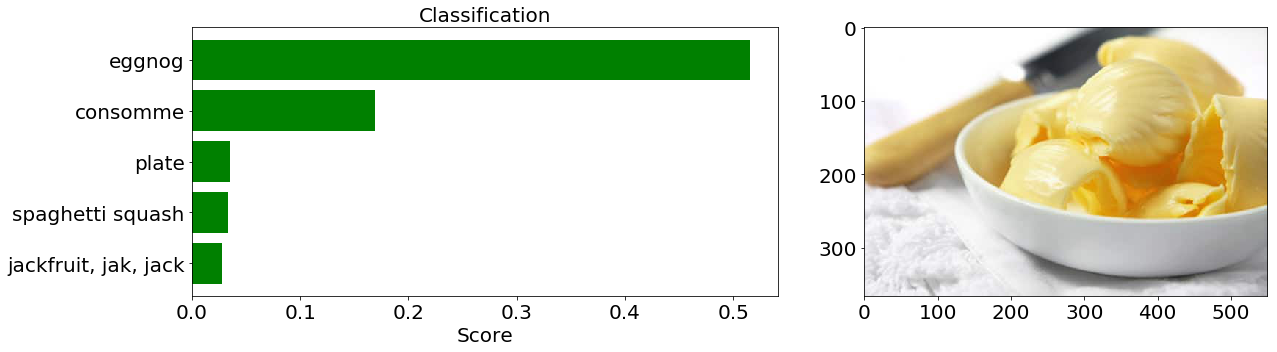

In [8]:
download_show_and_run('https://cdn.authoritynutrition.com/wp-content/uploads/2014/10/butter-in-a-small-bowl-550px.jpg', 'butter.jpg')

Intercepted!


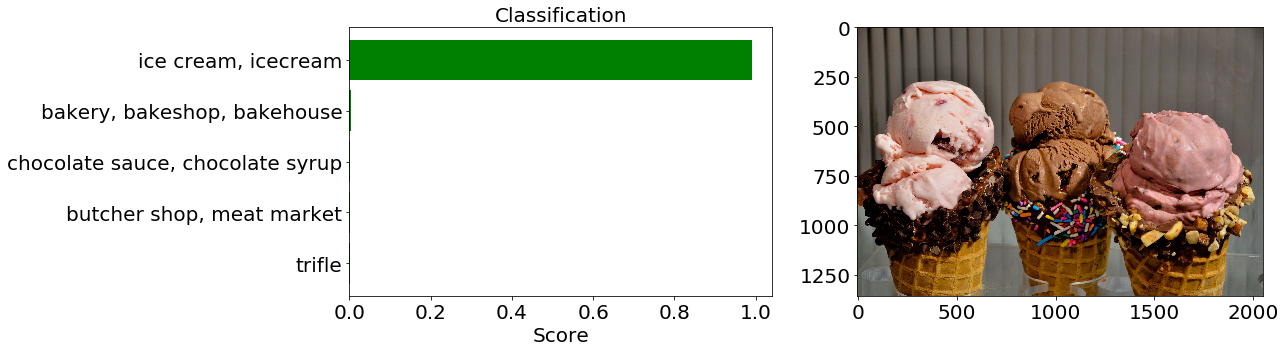

In [9]:
download_show_and_run('https://media.timeout.com/images/100914189/image.jpg', 'ice-cream.jpg')

rm: cannot remove '/tmp/imagenet/test.jpg': No such file or directory
Intercepted!


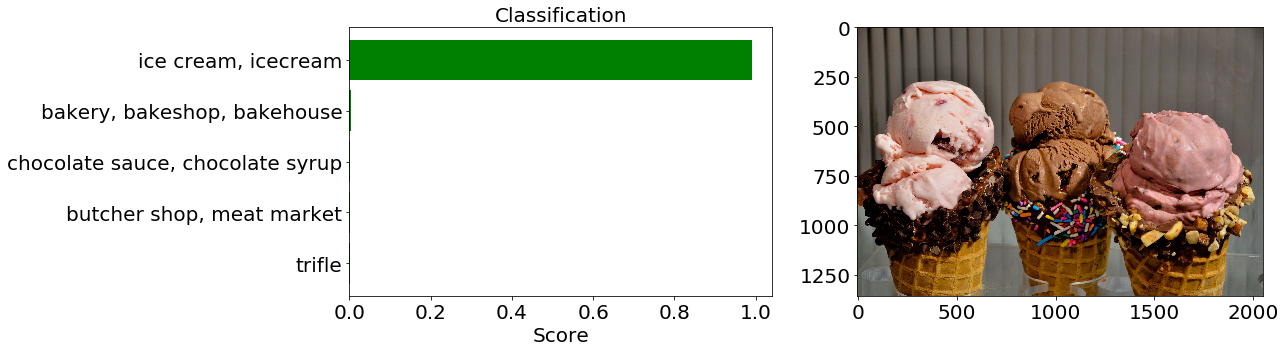

In [10]:
!rm /tmp/imagenet/test.jpg
url = 'https://media.timeout.com/images/100914189/image.jpg'
download_show_and_run(url, 'test.jpg')

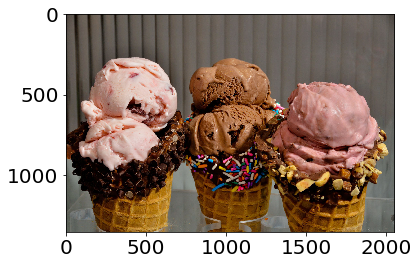

In [11]:
#!rm /tmp/imagenet/ice-cream.jpg
pil_im = Image.open('/tmp/imagenet/test.jpg', 'r')
plt.imshow(np.asarray(pil_im))